In [1]:
import fiona
import networkx as nx
import osmnx as ox
import geopandas as gp
import pandas as pd
from shapely.geometry import box

import numpy as np
from random import random

%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.1.1'

In [2]:
# get all building footprints in some neighborhood
place = "Bunker Hill, Los Angeles, California"
tags = {"building": True}
gdf = ox.geometries_from_address(place, tags, dist = 1200) # distance in meters
print(gdf.shape)

(2334, 119)


In [3]:
'''
    Preprocessing our GeoDataFrame

        1. Simplifying building geometries
        2. Adding centroids
        x. Removing some obstacles randomly (not for prod?)
'''

# envelope : convert to rectangles, simplify: reduce edges (also see shapely/geopandas docs)
simple = gdf['geometry'].convex_hull # REMOVING HOLES
simple = simple.simplify(0.5) # EDGE REDUCTION

# simple = gdf['geometry'].simplify(0.5) 
# simple = gdf['geometry'].envelope # RECTANGLE APPROXIMATION ORIENTED WITH THE AXES
gdf['geometry'] = simple

# gdf = gdf.set_crs("EPSG:3035", allow_override=True)
gdf['centroid'] = gdf.centroid

gdf = gdf.sample(frac=0.4)
print(gdf.shape)


<ipython-input-3-2e4edaf9e799>:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['centroid'] = gdf.centroid
(40252, 211)


In [ ]:
# fig, ax = ox.plot_footprints(gdf, figsize=(6, 6), color="blue", bgcolor = "white")

In [ ]:
# gdf['Latitude'] = gdf['centroid'].x
# gdf['Longitude'] = gdf['centroid'].y

# gdf.plot(figsize=(6, 6),edgecolor='black')


<AxesSubplot:>

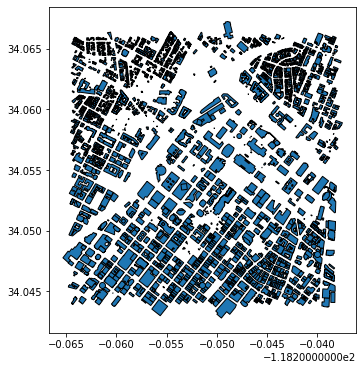

In [3]:
gdf.plot(figsize=(6, 6),edgecolor='black')

In [7]:
'''
    Building TARGET.
'''
# Random Target
# Target = gdf.sample(n=1)

# Specific Target
Target = gdf.loc[gdf['name'] == 'Bank of America Plaza']


<AxesSubplot:>

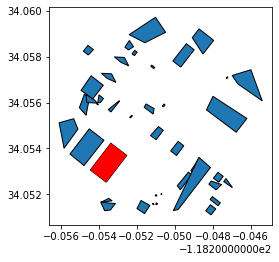

In [8]:
base = gdf.plot(edgecolor='black')
Target.plot(ax=base, color='red')

In [3]:
gdf = gp.read_file("datasets/obstacles2000.gpkg")

In [4]:
'''
    Building query points, all of them being at random locations.
    x = Longitude
    y = Latitude
'''
minx, miny, maxx, maxy = gdf.total_bounds

n_queryPoints = 128
coords = []
for _ in range(n_queryPoints//4):
    coords.append((minx,round( (maxy - miny)*random() + miny , 6 )))
for _ in range(n_queryPoints//4):
    coords.append((maxx,round( (maxy - miny)*random() + miny , 6 )))
for _ in range(n_queryPoints//4):
    coords.append( (round( (maxx - minx)*random()+minx , 6 ) ,miny) )
for _ in range(n_queryPoints//4):
    coords.append( (round( (maxx - minx)*random()+minx , 6 ) ,maxy) )

coords = np.asarray(coords)
lats = coords[:,1:].flatten()
longs = coords[:,:1].flatten()


In [5]:
qpDataframe = pd.DataFrame({
    'id': list(range(0,n_queryPoints)),
    'x': longs.tolist(),
    'y': lats.tolist(),
})

qpGdf = gp.GeoDataFrame(
    qpDataframe, geometry=gp.points_from_xy(qpDataframe.x, qpDataframe.y))



      id           x          y                     geometry
0      0 -118.274415  34.063580  POINT (-118.27442 34.06358)
1      1 -118.274415  34.037119  POINT (-118.27442 34.03712)
2      2 -118.274415  34.067670  POINT (-118.27442 34.06767)
3      3 -118.274415  34.055509  POINT (-118.27442 34.05551)
4      4 -118.274415  34.037656  POINT (-118.27442 34.03766)
..   ...         ...        ...                          ...
123  123 -118.248918  34.074759  POINT (-118.24892 34.07476)
124  124 -118.240506  34.074759  POINT (-118.24051 34.07476)
125  125 -118.247932  34.074759  POINT (-118.24793 34.07476)
126  126 -118.235604  34.074759  POINT (-118.23560 34.07476)
127  127 -118.263144  34.074759  POINT (-118.26314 34.07476)

[128 rows x 4 columns]


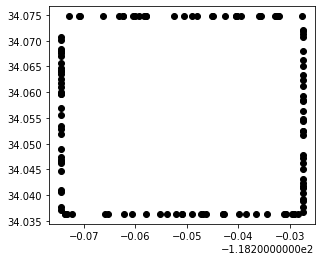

In [6]:
qpGdf.plot( color="black")
print(qpGdf)

In [185]:
# '''
#     Extracting to csv
# '''
# qpGdf.to_csv('querypoints.csv')
# Target.to_csv('target.csv')
# gdf.to_csv('obstacles.csv')

In [7]:
'''
    Extracting to files
'''
qpGdf.to_file('querypoints2000.gpkg', driver="GPKG")


# Target.to_file('target')

In [7]:
gdf2 = gdf.drop(columns=['height','fixme'])

In [8]:

gdf_save = gdf2.applymap(lambda x: str(x) if isinstance(x, list) else x)
gdf_save.drop(labels="nodes", axis=1).to_file("obstacles1200.gpkg", driver="GPKG")

In [7]:
gdf.head(5)

addr:state building  ele gnis:county_name  \
element_type osmid                                                 
node         368167018         CA      yes  100      Los Angeles   
             368167023         CA      yes   79      Los Angeles   
             368167034         CA      yes   66      Los Angeles   
             368167117         CA      yes   63      Los Angeles   
             368171571         CA   public  105      Los Angeles   

                       gnis:feature_id                      gnis:import_uuid  \
element_type osmid                                                             
node         368167018         1878583  57871b70-0100-4405-bb30-88b2e001a944   
             368167023         1877986  57871b70-0100-4405-bb30-88b2e001a944   
             368167034         1877879  57871b70-0100-4405-bb30-88b2e001a944   
             368167117         2129088  57871b70-0100-4405-bb30-88b2e001a944   
             368171571         2092075  57871b70-0100-4405-bb30-88b2e001a944   

                       gnis:reviewed  \
element_type osmid                     
node         368167018            no   
             368167023            no   
             368167034            no   
             368167117            no   
             368171571            no   

                                                                     name  \
element_type osmid                                                          
node         368167018  Soto Street Branch All Nations Neighborhood Ce...   
             368167023                          Catholic Charities Center   
             368167034                  Charles P Skauras Memorial Center   
             368167117                                   Ahmanson Commons   
             368171571            Los Angeles Municipal Arraignment Court   

                               source                     geometry  ...  \
element_type osmid                                                  ...   
node         368167018  USGS Geonames  POINT (-118.20896 34.04529)  ...   
             368167023  USGS Geonames  POINT (-118.27035 34.04946)  ...   
             368167034  USGS Geonames  POINT (-118.29980 34.04640)  ...   
             368167117  USGS Geonames  POINT (-118.27778 34.03083)  ...   
             368171571  USGS Geonames  POINT (-118.22944 34.09361)  ...   

                       building:levels:underground ways type roof:colour  \
element_type osmid                                                         
node         368167018                         NaN  NaN  NaN         NaN   
             368167023                         NaN  NaN  NaN         NaN   
             368167034                         NaN  NaN  NaN         NaN   
             368167117                         NaN  NaN  NaN         NaN   
             368171571                         NaN  NaN  NaN         NaN   

                       colour building:height capacity theatre:genre name:ko  \
element_type osmid                                                             
node         368167018    NaN             NaN      NaN           NaN     NaN   
             368167023    NaN             NaN      NaN           NaN     NaN   
             368167034    NaN             NaN      NaN           NaN     NaN   
             368167117    NaN             NaN      NaN           NaN     NaN   
             368171571    NaN             NaN      NaN           NaN     NaN   

                       name:de  
element_type osmid              
node         368167018     NaN  
             368167023     NaN  
             368167034     NaN  
             368167117     NaN  
             368171571     NaN  

[5 rows x 210 columns]